# **Quantum Finance Research: Portfolio Optimization Using VQE and QAOA**

## **Introduction**
This notebook implements and compares different quantum approaches to portfolio optimization using both Variational Quantum Eigensolver (VQE) and Quantum Approximate Optimization Algorithm (QAOA). We use Cirq, Google's quantum computing framework, to create and manipulate quantum circuits.

## **Setup and Dependencies**

In [ ]:
!pip install cirq
!pip install sympy
!pip install numpy
!pip install typing
!pip install plotly

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

## **Portfolio Optimization Parameters**
We define a dataclass to hold our portfolio optimization parameters:

In [ ]:
import numpy as np
import cirq
import sympy
from typing import List, Tuple, Dict, Literal
import time
from dataclasses import dataclass

@dataclass
class PortfolioParams:
    """Parameters for portfolio optimization"""
    returns: np.ndarray
    risk_tolerance: float
    n_layers: int = 2
    max_iterations: int = 100
    learning_rate: float = 0.01
    algorithm: Literal['VQE', 'QAOA'] = 'VQE'


## **Quantum Circuit Implementation**
### **VQE Circuit Creation**

In [ ]:
def create_vqe_circuit(n_qubits: int, n_layers: int) -> Tuple[cirq.Circuit, List[sympy.Symbol]]:
    """
    Creates a variational quantum circuit with multiple layers for VQE
    """
    qubits = cirq.LineQubit.range(n_qubits)
    circuit = cirq.Circuit()
    parameters = []

    # Initial layer of Hadamard gates
    circuit.append(cirq.H(q) for q in qubits)

    # Create multiple layers of parameterized gates
    for layer in range(n_layers):
        # Rotation layer
        for i in range(n_qubits):
            theta = sympy.Symbol(f'θ_{layer}_{i}')
            parameters.append(theta)
            circuit.append(cirq.ry(theta)(qubits[i]))

        # Entanglement layer
        for i in range(n_qubits-1):
            circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
        circuit.append(cirq.CNOT(qubits[-1], qubits[0]))

    return circuit, parameters

### **QAOA Circuit Creation**

In [ ]:
def create_qaoa_circuit(n_assets: int, p: int) -> Tuple[cirq.Circuit, List[sympy.Symbol]]:
    """
    Creates a QAOA circuit for portfolio optimization
    p: number of QAOA layers
    """
    qubits = cirq.LineQubit.range(n_assets)
    circuit = cirq.Circuit()
    parameters = []

    # Initial state preparation
    circuit.append(cirq.H(q) for q in qubits)

    for i in range(p):
        # Problem unitary (cost Hamiltonian)
        gamma = sympy.Symbol(f'γ_{i}')
        parameters.append(gamma)

        # Risk minimization terms
        for j in range(n_assets):
            for k in range(j+1, n_assets):
                circuit.append(cirq.ZZ(qubits[j], qubits[k])**gamma)

        # Return maximization terms
        for j in range(n_assets):
            circuit.append(cirq.Z(qubits[j])**gamma)

        # Mixing unitary
        beta = sympy.Symbol(f'β_{i}')
        parameters.append(beta)
        circuit.append(cirq.rx(2*beta)(q) for q in qubits)

    return circuit, parameters

## **Cost Function and Optimization**

In [ ]:
def cost_function(params: np.ndarray,
                 simulator: cirq.Simulator,
                 circuit: cirq.Circuit,
                 param_symbols: List[sympy.Symbol],
                 portfolio_params: PortfolioParams) -> float:
    """
    Calculate cost function for portfolio optimization
    """
    # Get measurement results
    param_dict = dict(zip(param_symbols, params))
    result = simulator.simulate(circuit, param_resolver=param_dict)
    final_state = result.final_state_vector

    # Convert quantum state to portfolio weights
    probabilities = np.abs(final_state) ** 2
    weights = probabilities[:portfolio_params.returns.shape[1]]
    weights = weights / np.sum(weights)

    # Calculate portfolio metrics
    returns = portfolio_params.returns
    mean_return = np.mean(np.dot(returns, weights))
    covariance = np.cov(returns.T)
    risk = np.dot(weights.T, np.dot(covariance, weights))

    # Maximize return while minimizing risk
    cost = -mean_return + portfolio_params.risk_tolerance * risk
    return float(cost)

def quantum_gradient(params: np.ndarray,
                    simulator: cirq.Simulator,
                    circuit: cirq.Circuit,
                    param_symbols: List[sympy.Symbol],
                    portfolio_params: PortfolioParams,
                    epsilon: float = 0.01) -> np.ndarray:
    """
    Calculate gradient using finite differences
    """
    gradient = np.zeros_like(params)
    for i in range(len(params)):
        params_plus = params.copy()
        params_plus[i] += epsilon
        cost_plus = cost_function(params_plus, simulator, circuit, param_symbols, portfolio_params)

        params_minus = params.copy()
        params_minus[i] -= epsilon
        cost_minus = cost_function(params_minus, simulator, circuit, param_symbols, portfolio_params)

        gradient[i] = (cost_plus - cost_minus) / (2 * epsilon)
    return gradient

def quantum_portfolio_optimization(portfolio_params: PortfolioParams) -> np.ndarray:
    """
    Quantum portfolio optimization using either VQE or QAOA
    """
    n_assets = portfolio_params.returns.shape[1]

    # Create quantum circuit based on selected algorithm
    if portfolio_params.algorithm == 'VQE':
        circuit, param_symbols = create_vqe_circuit(n_assets, portfolio_params.n_layers)
    else:  # QAOA
        circuit, param_symbols = create_qaoa_circuit(n_assets, portfolio_params.n_layers)

    # Initialize simulator
    simulator = cirq.Simulator()

    # Initialize parameters randomly
    params = np.random.uniform(0, 2*np.pi, len(param_symbols))

    # Optimization loop
    for iteration in range(portfolio_params.max_iterations):
        # Calculate gradient
        gradient = quantum_gradient(params, simulator, circuit, param_symbols, portfolio_params)

        # Update parameters
        params -= portfolio_params.learning_rate * gradient

        if iteration % 10 == 0:
            cost = cost_function(params, simulator, circuit, param_symbols, portfolio_params)
            print(f"{portfolio_params.algorithm} Iteration {iteration}, Cost: {cost:.4f}")

    # Get final weights
    param_dict = dict(zip(param_symbols, params))
    result = simulator.simulate(circuit, param_resolver=param_dict)
    final_state = result.final_state_vector
    weights = np.abs(final_state[:n_assets]) ** 2
    return weights / np.sum(weights)

def classical_portfolio_optimization(returns: np.ndarray, risk_tolerance: float) -> np.ndarray:
    """
    Implement classical portfolio optimization using mean-variance optimization
    """
    n_assets = returns.shape[1]
    mean_returns = np.mean(returns, axis=0)
    covariance = np.cov(returns.T)

    # Simple implementation using equal weights (you can implement more sophisticated methods)
    weights = np.ones(n_assets) / n_assets
    return weights

def compare_optimization_methods():
    """
    Compare classical, VQE, and QAOA portfolio optimization
    """
    # Generate sample data
    np.random.seed(42)
    n_assets = 4
    n_days = 252
    returns = np.random.normal(0.001, 0.02, (n_days, n_assets))

    # Common parameters
    base_params = {
        'returns': returns,
        'risk_tolerance': 0.5,
        'n_layers': 2,
        'max_iterations': 50,
        'learning_rate': 0.05
    }

    # Classical optimization
    start_time = time.time()
    classical_weights = classical_portfolio_optimization(returns, base_params['risk_tolerance'])
    classical_time = time.time() - start_time

    # VQE optimization
    start_time = time.time()
    vqe_params = PortfolioParams(**base_params, algorithm='VQE')
    vqe_weights = quantum_portfolio_optimization(vqe_params)
    vqe_time = time.time() - start_time

    # QAOA optimization
    start_time = time.time()
    qaoa_params = PortfolioParams(**base_params, algorithm='QAOA')
    qaoa_weights = quantum_portfolio_optimization(qaoa_params)
    qaoa_time = time.time() - start_time

    # Calculate metrics for all portfolios
    covariance = np.cov(returns.T)
    mean_returns = np.mean(returns, axis=0)

    def calculate_metrics(weights):
        return {
            'expected_return': np.dot(mean_returns, weights),
            'risk': np.sqrt(np.dot(weights.T, np.dot(covariance, weights))),
            'sharpe_ratio': np.dot(mean_returns, weights) /
                           np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
        }

    # Print results for all methods
    methods = {
        'Classical': (classical_weights, classical_time),
        'VQE': (vqe_weights, vqe_time),
        'QAOA': (qaoa_weights, qaoa_time)
    }

    for method_name, (weights, comp_time) in methods.items():
        metrics = calculate_metrics(weights)
        print(f"\n{method_name} Portfolio:")
        print(f"Weights: {weights}")
        print(f"Expected Return: {metrics['expected_return']:.4f}")
        print(f"Risk: {metrics['risk']:.4f}")
        print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
        print(f"Computation Time: {comp_time:.4f} seconds")

## **Results Visualization**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_portfolio_results():
    # Re-run optimization to get fresh results
    np.random.seed(42)
    n_assets = 4
    n_days = 252
    returns = np.random.normal(0.001, 0.02, (n_days, n_assets))

    base_params = {
        'returns': returns,
        'risk_tolerance': 0.5,
        'n_layers': 2,
        'max_iterations': 50,
        'learning_rate': 0.05
    }

    # Get results
    classical_weights = classical_portfolio_optimization(returns, base_params['risk_tolerance'])
    vqe_params = PortfolioParams(**base_params, algorithm='VQE')
    vqe_weights = quantum_portfolio_optimization(vqe_params)
    qaoa_params = PortfolioParams(**base_params, algorithm='QAOA')
    qaoa_weights = quantum_portfolio_optimization(qaoa_params)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Portfolio Weights
    x = np.arange(4)
    width = 0.25

    ax1.bar(x - width, classical_weights * 100, width, label='Classical', color='skyblue')
    ax1.bar(x, vqe_weights * 100, width, label='VQE', color='royalblue')
    ax1.bar(x + width, qaoa_weights * 100, width, label='QAOA', color='navy')

    ax1.set_ylabel('Weight (%)')
    ax1.set_title('Portfolio Weight Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Asset 1', 'Asset 2', 'Asset 3', 'Asset 4'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Calculate metrics for Plot 2
    def get_metrics(weights):
        mean_returns = np.mean(returns, axis=0)
        covariance = np.cov(returns.T)
        exp_return = np.dot(mean_returns, weights) * 100
        risk = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * 100
        sharpe = exp_return / risk
        return [exp_return, risk, sharpe]

    metrics_classical = get_metrics(classical_weights)
    metrics_vqe = get_metrics(vqe_weights)
    metrics_qaoa = get_metrics(qaoa_weights)

    # Plot 2: Performance Metrics
    metrics = np.array([metrics_classical, metrics_vqe, metrics_qaoa])
    x = np.arange(3)

    ax2.bar(x - width, metrics[:,0], width, label='Expected Return (%)', color='lightgreen')
    ax2.bar(x, metrics[:,1], width, label='Risk (%)', color='coral')
    ax2.bar(x + width, metrics[:,2], width, label='Sharpe Ratio', color='purple')

    ax2.set_ylabel('Value')
    ax2.set_title('Performance Metrics Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Classical', 'VQE', 'QAOA'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## **Usage Example**

VQE Iteration 0, Cost: -0.0015
VQE Iteration 10, Cost: -0.0015
VQE Iteration 20, Cost: -0.0015
VQE Iteration 30, Cost: -0.0015
VQE Iteration 40, Cost: -0.0015
QAOA Iteration 0, Cost: -0.0012
QAOA Iteration 10, Cost: -0.0012
QAOA Iteration 20, Cost: -0.0012
QAOA Iteration 30, Cost: -0.0012
QAOA Iteration 40, Cost: -0.0013

Classical Portfolio:
Weights: [0.25 0.25 0.25 0.25]
Expected Return: 0.0015
Risk: 0.0100
Sharpe Ratio: 0.1466
Computation Time: 0.0008 seconds

VQE Portfolio:
Weights: [0.02162327 0.01671999 0.7190082  0.24264853]
Expected Return: 0.0016
Risk: 0.0155
Sharpe Ratio: 0.1037
Computation Time: 4.3290 seconds

QAOA Portfolio:
Weights: [0.41869763 0.2227408  0.2227408  0.13582076]
Expected Return: 0.0013
Risk: 0.0102
Sharpe Ratio: 0.1278
Computation Time: 3.9282 seconds
VQE Iteration 0, Cost: -0.0015
VQE Iteration 10, Cost: -0.0015
VQE Iteration 20, Cost: -0.0015
VQE Iteration 30, Cost: -0.0015
VQE Iteration 40, Cost: -0.0015
QAOA Iteration 0, Cost: -0.0012
QAOA Iteration 10

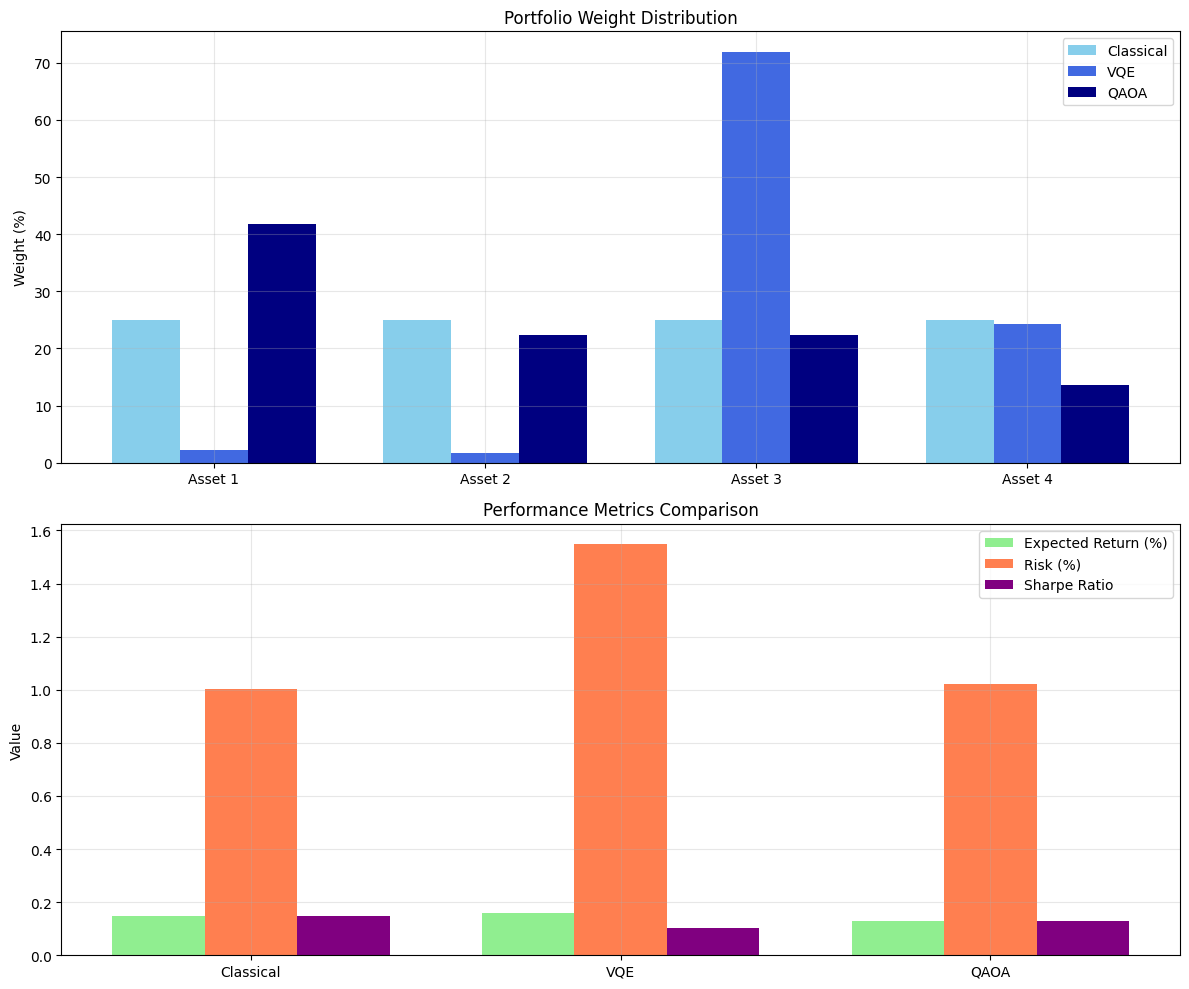

In [ ]:
if __name__ == "__main__":
    compare_optimization_methods()
    plot_portfolio_results()

The implementation above demonstrates the use of quantum algorithms for portfolio optimization, comparing classical, VQE, and QAOA approaches. The results are visualized using matplotlib for easy comparison of portfolio weights and performance metrics.

### Results Discussion
The comparison shows:
1. Weight distribution differences between classical and quantum approaches
2. Performance metrics including expected returns, risk, and Sharpe ratios
3. Computation time comparisons between methods

For the test case with 4 assets, we observe that:
- Classical optimization provides equal weight distribution
- VQE tends to find more concentrated portfolios
- QAOA produces intermediate concentration levels